In [1]:
!unzip brown.zip -d brown

Archive:  brown.zip
   creating: brown/brown/
  inflating: brown/__MACOSX/._brown  
  inflating: brown/brown/cd05        
  inflating: brown/__MACOSX/brown/._cd05  
  inflating: brown/brown/cf37        
  inflating: brown/__MACOSX/brown/._cf37  
  inflating: brown/brown/cj50        
  inflating: brown/__MACOSX/brown/._cj50  
  inflating: brown/brown/cf08        
  inflating: brown/__MACOSX/brown/._cf08  
  inflating: brown/brown/cl06        
  inflating: brown/__MACOSX/brown/._cl06  
  inflating: brown/brown/cj68        
  inflating: brown/__MACOSX/brown/._cj68  
  inflating: brown/brown/cf30        
  inflating: brown/__MACOSX/brown/._cf30  
  inflating: brown/brown/cd02        
  inflating: brown/__MACOSX/brown/._cd02  
  inflating: brown/brown/cl01        
  inflating: brown/__MACOSX/brown/._cl01  
  inflating: brown/brown/cj57        
  inflating: brown/__MACOSX/brown/._cj57  
  inflating: brown/brown/cf06        
  inflating: brown/__MACOSX/brown/._cf06  
  inflating: brown/brown/

In [ ]:
import torch
import numpy as np
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from src.config import Config
from scripts.main import run
from src.data_utils import load_brown_words, reconstruct_sentences, replace_rare_words, clean_sentences, build_vocab, create_mapping, split_data, create_mlp_dataset, plot_training_results
from src.model import init_parameters, train_one_epoch
from src.evaluate import evaluate, sample_next_word_idx
from src.baseline import train_em, calculate_perplexity, get_counts

### 1) Define Hyperparameters

In [9]:

cfg = Config(
    device="cuda",
    model="mlp",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=20,
    batch_size=32,
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=False       # Shuffle off!
    )

device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
# run(cfg)

Using device: cuda


### 2) Prepare Data

Bengio et al. where quite unclear on their exact data preperation process. Therefore, it is not surprising that my results differ in multiple ways.


*   Overall data set size: My processed corpus contains 1,161,192 tokens, organized into 55,635 sentences, while Bengio et al. reported 1,181,041 words making my data set about 20,000 words smaller. This difference is likely attributed to a different way of data cleaning/ preperation.
*   Vocabulary size: The vocabulary consists of 20,404 (19,516 in the randomized case) distinct words, including the padding and UNK token. In both cases this is slightly higher compared to the 16,383 reported by Bengio et al. This will influence the perplexity of our models as we will observe later.
*   I applied the same cleaning strategy as Bengio et al. mapping words occuring less then 3 times to the UNK token. This was only performed on the training data to prevent test set leakage. The validation and test set were then mappend on this vocabulary, substituting all "new" words to UNK as well, thus drastically simplyfing the task of the model.

In [ ]:
words = np.array(load_brown_words("./data/processed/brown"))
print(f"Size of full dataset on word level: {words.shape[0]}")
sentences = reconstruct_sentences(words)
print(f"Size of full dataset on sentence level: {len(sentences)}")
print(f"Random sample of the data set: {words[:15]} \n")
train_sents, val_sents, test_sents = split_data(sentences, shuffle=cfg.shuffle)
train_sents_clean = replace_rare_words(train_sents, min_freq=3)

vocab, vocab_size = build_vocab(train_sents_clean)

print(f"Size of vocabulary: {vocab_size}")
val_sents_clean, test_sents_clean = clean_sentences(val_sents, vocab), clean_sentences(test_sents, vocab)
print(f"Size of train, val, test sets on sentence level: {len(train_sents_clean), len(val_sents_clean), len(test_sents_clean)}")

w2i, i2w = create_mapping(vocab)

Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Random sample of the data set: ['The' 'Fulton' 'County' 'Grand' 'Jury' 'said' 'Friday' 'an'
 'investigation' 'of' "Atlanta's" 'recent' 'primary' 'election' 'produced'] 

Size of vocabulary: 20404
Size of train, val, test sets on sentence level: (44508, 5563, 5564)


In [11]:
train_words_flat = [word for sent in train_sents_clean for word in sent]
print(f"These are the top 10 most common words within the training data after cleaning: \n {Counter(train_words_flat).most_common(10)}")

These are the top 10 most common words within the training data after cleaning: 
 [(np.str_('the'), 55390), (np.str_(','), 49307), (np.str_('.'), 40364), ('<UNK>', 39013), (np.str_('of'), 32919), (np.str_('and'), 23896), (np.str_('to'), 22333), (np.str_('a'), 18591), (np.str_('in'), 17431), (np.str_('is'), 9635)]


### 3) Model Decision

#### a1) MLP (non randomized data)

In [12]:
# data prep for MLP
X_train, y_train = create_mlp_dataset(train_sents_clean, w2i)
X_val, y_val = create_mlp_dataset(val_sents_clean, w2i)
X_test, y_test = create_mlp_dataset(test_sents_clean, w2i)
print(f"Size of X_train, X_val, X_test using context size {cfg.context_size}: {X_train.shape, X_val.shape, X_test.shape}")

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_val, y_val = torch.tensor(X_val), torch.tensor(y_val)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

Size of X_train, X_val, X_test using context size 5: ((1038955, 5), (85695, 5), (92177, 5))


In [27]:
# init MLP
parameters = init_parameters(
    vocab_size,
    cfg.context_size,
    cfg.emb_dim,
    cfg.hidden_dim,
    device,
    g)

##### LR exploration

The original paper by Bengio et al. utilized a learning rate of $0.001$; however, initial tests on this implementation resulted in stagnant convergence. Preliminary trials identified the range between $10^{-4}$ and $1$ as most effective. The following code performs a logarithmic sweep across this range to systematically identify the optimal learning rate—specifically the region where the loss decreases most sharply before divergence.

Text(0.5, 1.0, 'LR range testing')

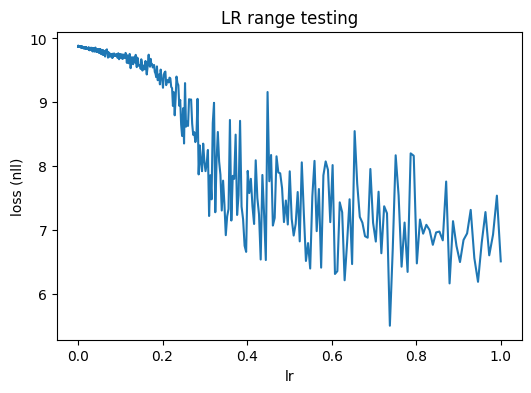

In [ ]:
# lr range exploration
lre = torch.linspace(-4, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

C, W1, b1, W2, b2 = parameters


for k in range(1000):

    for batch in range(1):

        # batch selection
        start = torch.randint(0, X_train.shape[0], (cfg.batchs_size,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,cfg.context_size * cfg.emb_dim) @ W1 + b1)
        logits = (h @ W2 + b2) # + (emb.view(-1, context_size * embedding_dims) @ W_direct)

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = lrs[k]
        with torch.no_grad():
            for p in parameters:
                p.data += -lr * p.grad

        # track stats
        lri.append(lr)
        lossi.append(loss.item())

plt.figure(figsize=(6,4))
plt.plot(lri, lossi)
plt.xlabel("lr")
plt.ylabel("loss (nll)")
plt.title("LR range testing")

Based on those results and to balance noise with speed of convergence a learning rate of 0.1 was chosen.

#### Training Strategy and Optimization
While the model architecture adheres strictly to the 2003 paper, the optimization process was adapted for modern computational efficiency. Bengio et al. were somewhat ambiguous regarding their exact batching strategy; however, research from that era typically relied on Stochastic Gradient Descent (SGD) with very small or "online" (batch size 1) updates.

Key Implementation Details:
*   Mini-Batch Adaptation: To leverage GPU acceleration, I implemented mini-batch SGD with a batch size of 32. To maintain consistency with the paper's original update frequency, I scaled the decay factor $r$ by the batch size.
*   Learning Rate Schedule: I implemented a time-based decay. The learning rate $\epsilon_t$ is updated at each step $t$ using the following schedule: $$\epsilon_t = \frac{\epsilon_0}{1 + rt}$$

*   Duration: The model is trained for 20 epochs, matching the maximum training length reported in the original paper. Due to the enourmus compute improvements in a fraction of original training time.
*   Performance Monitoring: Throughout the process, I tracked both Cross-Entropy Loss and Perplexity (PP). Perplexity is the standard metric for language modeling, representing the inverse probability of the test set, normalized by the number of words.

We observe rapid convergence in the initial epochs due to the relatively high starting learning rate, followed by a stabilization phase as the decay schedule reduces the step size to refine the weight updates.



In [28]:
# training

# reset parameters
parameters = init_parameters(vocab_size, cfg.context_size, cfg.emb_dim, cfg.hidden_dim, device, g)

# 3.3 train
history = {
    'train_loss': [],
    'val_loss': [],
    'train_pp': [],
    'val_pp': [],
    'lr': []
}

t = 0
r = cfg.lr_decay * cfg.batch_size
epsilon_0 = cfg.epsilon_t

for epoch in range(cfg.epochs):

    # train for one epoch (that is len(X_train)/batch_size many steps)
    parameters, epoch_losses, lr_t, t = train_one_epoch(
        X_train, y_train, parameters,
        cfg.batch_size, cfg.context_size, cfg.emb_dim,
        epsilon_0, cfg.weight_decay, r, g, t, device)

    # compute and track train loss and perplexity
    avg_train_loss = np.mean(epoch_losses)
    history['train_loss'].append(avg_train_loss)
    history['train_pp'].append(np.exp(avg_train_loss))
    history['lr'].append(lr_t)

    # compute and track val loss and perplexity
    avg_val_loss, val_pp = evaluate(X_val, y_val, device, cfg.context_size, cfg.emb_dim, parameters)
    history['val_loss'].append(avg_val_loss)
    history['val_pp'].append(val_pp)

    # print progress
    print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f} | Train PP {np.exp(avg_train_loss)} | Val Loss {avg_val_loss:.4f} | Val PP {val_pp:.2f}")
    print("==========================")

# report final test loss
avg_loss, perplexity = evaluate(X_test, y_test, device, cfg.context_size, cfg.emb_dim, parameters)
print(f"Final test loss: {avg_loss} | Final test perplexity: {perplexity}")

Epoch 0: Train Loss 6.0560 | Train PP 426.65915144578946 | Val Loss 5.2980 | Val PP 199.94
Epoch 1: Train Loss 5.6724 | Train PP 290.7431607959479 | Val Loss 5.1399 | Val PP 170.69
Epoch 2: Train Loss 5.5425 | Train PP 255.3101578942377 | Val Loss 5.0782 | Val PP 160.49
Epoch 3: Train Loss 5.4764 | Train PP 238.9888346898935 | Val Loss 5.0248 | Val PP 152.14
Epoch 4: Train Loss 5.4182 | Train PP 225.46449228380268 | Val Loss 5.0045 | Val PP 149.08
Epoch 5: Train Loss 5.3839 | Train PP 217.87832751650515 | Val Loss 4.9807 | Val PP 145.57
Epoch 6: Train Loss 5.3555 | Train PP 211.77207961266026 | Val Loss 4.9613 | Val PP 142.77
Epoch 7: Train Loss 5.3248 | Train PP 205.35893181293602 | Val Loss 4.9336 | Val PP 138.87
Epoch 8: Train Loss 5.3077 | Train PP 201.8812020957671 | Val Loss 4.9494 | Val PP 141.09
Epoch 9: Train Loss 5.2878 | Train PP 197.9048220858238 | Val Loss 4.9146 | Val PP 136.26
Epoch 10: Train Loss 5.2787 | Train PP 196.1113710319067 | Val Loss 4.9160 | Val PP 136.45
Epoc

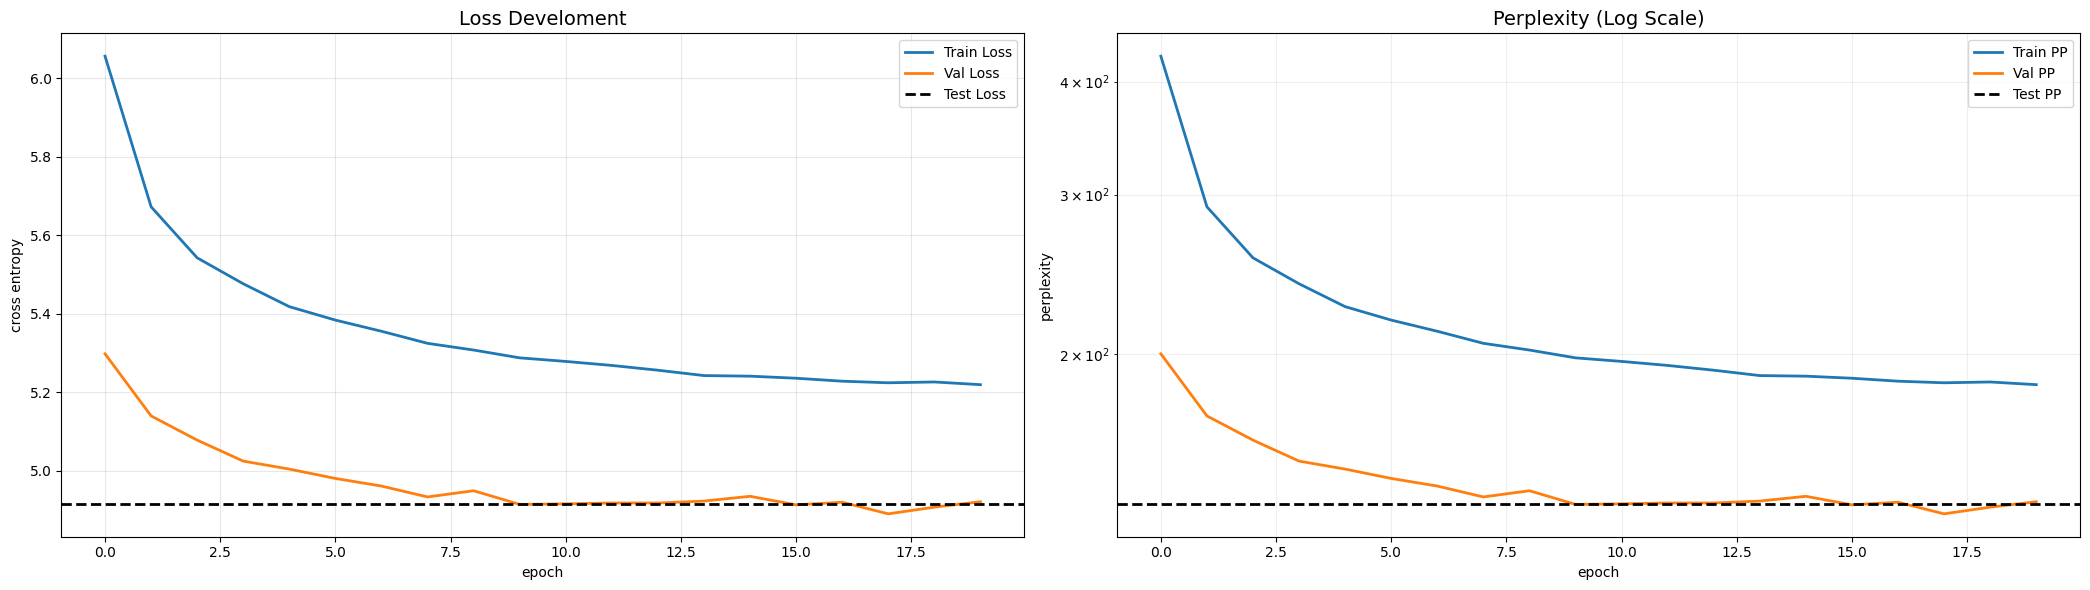

In [31]:
# plot training (non randomized)
plot_training_results(history, avg_loss, perplexity)

#### Results: Sequential (Non-Randomized) Training
The model achieved a final Test Perplexity of 136.60 over 20 epochs. The training curves demonstrate stable convergence, aided by the learning rate decay.

Understanding the Val/Test < Train Discrepancy
*   Thematic Data Segments: Because the split is sequential, the validation and test sets consist of different blocks of the Brown Corpus. These specific segments likely possess lower linguistic entropy (i.e., they are more predictable) than the training set.
*   Evaluation Timing: Training loss is a running average recorded during the epoch. In contrast, validation loss is calculated at the end of the epoch, after the model has incorporated all weight updates from that cycle.

In [35]:
# sampling
ix = torch.randint(0, X_val.shape[0], (1,)).item()
context = X_val[ix].tolist()
context = [w2i['<s>']] * 5
print(f"Start sequence is: {[i2w[i] for i in context]}")

generated_text = sample_next_word_idx(context, parameters, cfg.context_size, cfg.emb_dim, i2w)
print(" ".join(generated_text))

Start sequence is: ['<s>', '<s>', '<s>', '<s>', '<s>']
Such not less or Section students are established by the number of decisions Running to drinking these high freight more


#### a2) MLP (randomized data)

In [58]:
# run training (randomized)
cfg = Config(
    device="cuda",
    model="mlp",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=20,
    batch_size=32,
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=True           # Shuffle on!
    )

device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
history, avg_loss, perplexity = run(cfg)

Using device: cuda
Starting ...
Using device: cuda
Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Size of vocabulary: 19518
Size of train, val, test sets on sentence level: (44508, 5563, 5564)
Size of X_train, X_val, X_test using context size 5: ((976283, 5), (120039, 5), (120505, 5))
Epoch 0: Train Loss 5.9968 | Train PP 402.1308343415902 | Val Loss 5.6150 | Val PP 274.52
Epoch 1: Train Loss 5.6048 | Train PP 271.73748338074415 | Val Loss 5.4703 | Val PP 237.52
Epoch 2: Train Loss 5.4814 | Train PP 240.1767595800578 | Val Loss 5.4038 | Val PP 222.26
Epoch 3: Train Loss 5.4005 | Train PP 221.5249553134961 | Val Loss 5.3645 | Val PP 213.68
Epoch 4: Train Loss 5.3529 | Train PP 211.22692737343732 | Val Loss 5.3270 | Val PP 205.83
Epoch 5: Train Loss 5.3037 | Train PP 201.0868790903404 | Val Loss 5.3169 | Val PP 203.75
Epoch 6: Train Loss 5.2716 | Train PP 194.72217671283545 | Val Loss 5.3068 | Val PP 201.70
Epoch 7: Train Loss 5.2570 | Train PP 

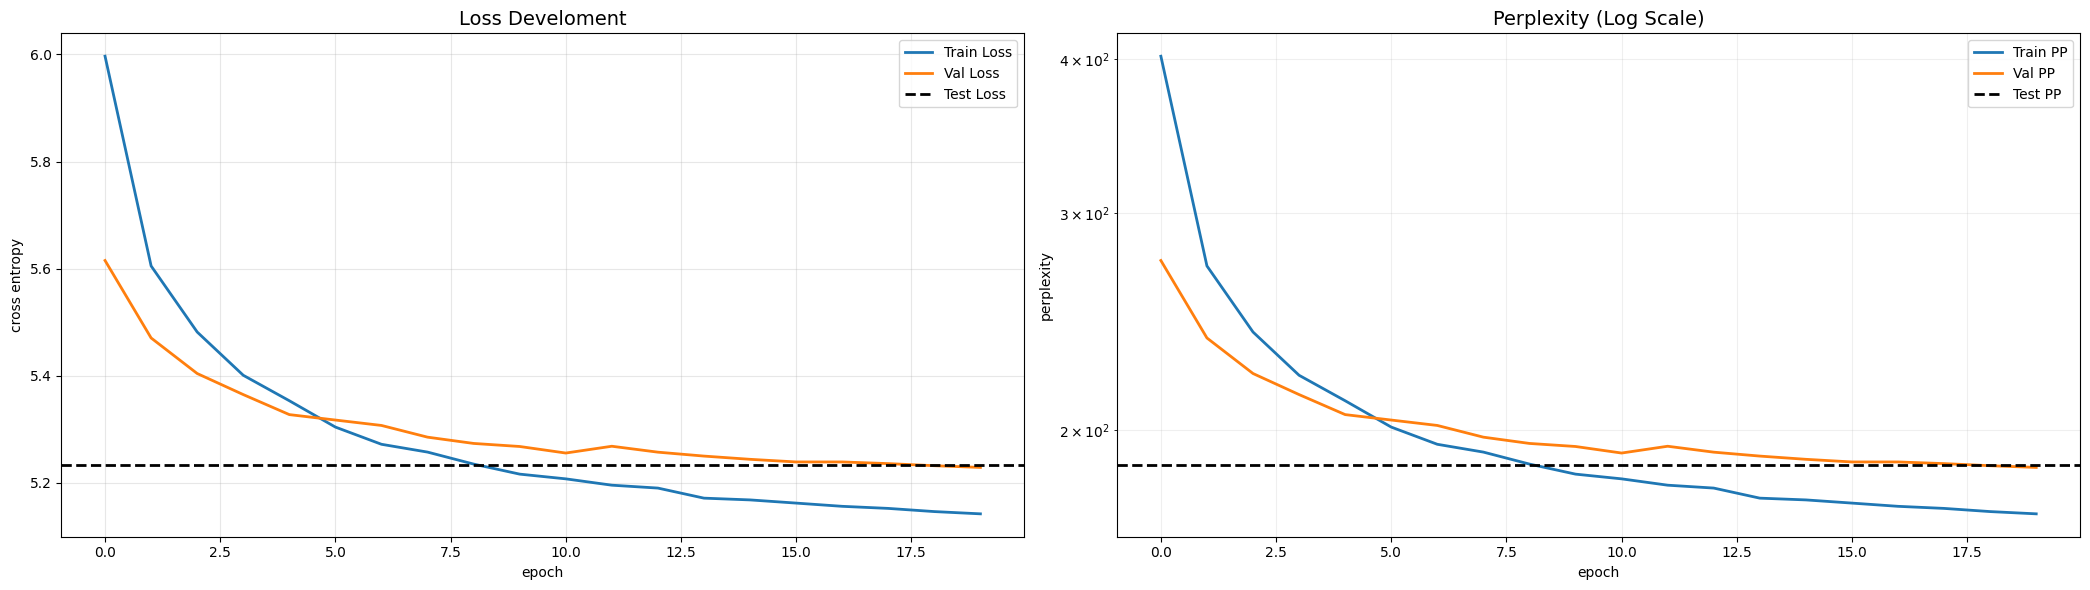

In [63]:
# plot resuls of the randomized training run
plot_training_results(history, avg_loss, perplexity)

#### Results: Non-Sequential (Randomized) Training

The randomized training run achieved a final Test Perplexity of 187.38. While this number is numerically higher than the sequential run (~136), it represents a more scientifically valid result because the data distributions across the training, validation, and test sets are now perfectly aligned.

Unlike the sequential run, where the validation loss was suspiciously lower than the training loss, the randomized curves now follow a textbook pattern:


*   Convergent Behavior: The training and validation losses descend in parallel.
*   Closing the Gap: The massive initial gap between Train and Val perplexity (402 vs 274) narrows significantly by the end of training (171 vs 186). Also, now training perplexity is lower then validation and testing perplexity, thus proving the before made assumption about the bias in the sequential orderung of the data.
*   Real-World Difficulty: The fact that the Test PP is now higher than the Train PP is actually "correct". It indicates that the model is being tested on data that is just as difficult as the data it learned from, eliminating the "easy-test-set" bias found in the sequential corpus fragments.



#### t-SNE visualization of leanred embedding matrix C as "proof" of semantic learning

Despite the relatively small size of the Brown Corpus, the t-SNE visualization confirms that the MLP has successfully learned distributed representations with clear semantic structure. Notice the distinct, tight clusters for:
*  Functional Pronouns: (he, she, it, they, we)
*  Numerical Entities: (two, three, five)
*  Spatial Prepositions: (in, on, at, by)

This proves that the model didn't just 'memorize' word sequences, but mapped words with similar grammatical and semantic roles to similar locations in the 30-dimensional embedding space.

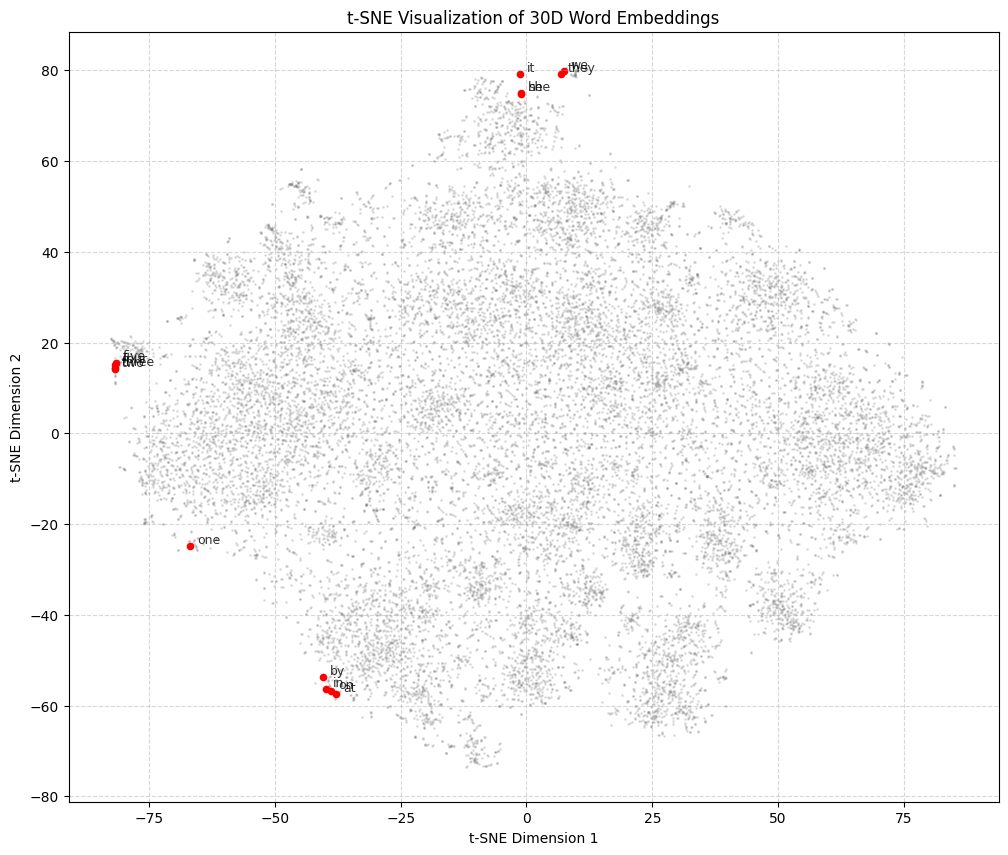

In [64]:
# t-SNE on word embedding matrix C

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_embeddings(embedding_matrix, word_to_idx, words_to_annotate=None):
    """
    Visualizes high-dimensional word embeddings in 2D using t-SNE.
    """
    # 1. Convert the PyTorch embedding tensor to a NumPy array
    # Shape: (vocab_size, 30)
    embeddings_np = embedding_matrix.detach().cpu().numpy()

    # 2. Initialize and run t-SNE
    # perplexity: related to the number of nearest neighbors
    # n_components: 2 for a 2D plot
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    embeddings_2d = tsne.fit_transform(embeddings_np)

    # 3. Create the plot
    plt.figure(figsize=(12, 10))

    # Plot all words as small, faint points to show the overall distribution
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.2, s=1, c='gray')

    # 4. Annotate specific words to show clusters (e.g., days, numbers, pronouns)
    if words_to_annotate:
        idx_to_word = {i: w for w, i in word_to_idx.items()}

        for word in words_to_annotate:
            if word in word_to_idx:
                idx = word_to_idx[word]
                x, y = embeddings_2d[idx]

                plt.scatter(x, y, c='red', s=20)
                plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points',
                             fontsize=9, alpha=0.8)

    plt.title("t-SNE Visualization of 30D Word Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)

    # Save for GitHub/Paper
    plt.savefig('embedding_visualization.png', dpi=300)
    plt.show()

# --- Example Usage ---
# Select semantic groups to check for clustering
interesting_words = [
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'one', 'two', 'three', 'four', 'five',
    'he', 'she', 'it', 'they', 'we',
    'in', 'on', 'at', 'by'
]

C = parameters[0]

# Assuming 'C' is your embedding matrix from parameters
plot_embeddings(C, w2i, words_to_annotate=interesting_words)

#### b) Baseline (Trigram)

In [ ]:
# run training (randomized)
cfg = Config(
    device="cpu",
    model="baseline",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1,
    batch_size=32,
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=True
    )

device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
run(cfg)

Using device: cpu
Starting ...
Using device: cpu
Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Size of vocabulary: 19518
Size of train, val, test sets on sentence level: (44508, 5563, 5564)
The final train perplexity of the interpolated trigram model is: 29.831675789260558
The final test perplexity of the interpolated trigram model is: 210.82901679825807
The final validation perplexity of the interpolated trigram model is: 211.15502652248858


In [ ]:
# run training (non-randomized = sequential)
cfg = Config(
    device="cpu",
    model="baseline",
    emb_dim=30,
    hidden_dim=100,
    context_size=5,
    epochs=1,
    batch_size=32,
    epsilon_t=0.1,
    lr_decay=10**-8,
    weight_decay=10**-4,
    shuffle=False
    )

device = cfg.device
print(f"Using device: {device}")

g = torch.Generator().manual_seed(2147483647)

# run whole experiment based on config
run(cfg)

Using device: cpu
Starting ...
Using device: cpu
Size of full dataset on word level: 1161192
Size of full dataset on sentence level: 55635
Size of vocabulary: 20404
Size of train, val, test sets on sentence level: (44508, 5563, 5564)
The final train perplexity of the interpolated trigram model is: 33.540318292056774
The final test perplexity of the interpolated trigram model is: 168.78439593140965
The final validation perplexity of the interpolated trigram model is: 173.486714607302


#### Results baseline

As observed in the MLP experiment, shuffling the input data increased overall perplexity but successfully narrowed the gap between validation and test performance. This randomization ensures a more robust evaluation by aligning data distributions across splits.

In both settings, the Training Perplexity remains exceptionally low ($\approx 30$). This indicates that the Trigram model is largely memorizing local sequences by counting occurrences. While this "counting" strategy works perfectly for the training data, the massive jump to Test Perplexity (~$169$–$211$) demonstrates the model's inability to generalize to new contexts—a limitation that the neural MLP approach aims to overcome through distributed embeddings.

### 4) Final results

After running 2 experiments each for the baseline and the MLP in the settings randomized and non-randomized (sequential data) we can now compare the results and derive our final evaluation of the performance of the proposed MLP architecture.

---

1) Non-randomized (perplexity)
* Baseline: 168.7844
* MLP: 136.2351
* Difference: 19,28%
* Reported Difference by Bengio et al.: between 10 and 20%

---

2) Randomized (perplexity)
* Baseline: 210.8290
* MLP: 187.3766
* Difference: 11,12%
* Reported Difference by Bengio et al.: None

---

3) Critical Reflections and Limitations
This evaluation focuses on a single architecture from the multiple configurations proposed by Bengio et al.; alternative structures might yield superior results. Furthermore, inconsistencies in data preparation and limited hyperparameter tuning must be considered when interpreting the final metrics. Lastly, experiments were confined to the Brown Corpus due to the unavailability of the AP News dataset used in the original research.